In [ ]:
import os
from dotenv import load_dotenv
import huggingface_hub

# load env var huggingface token
load_dotenv(os.path.join("../", ".env"))
# login to the hub
huggingface_hub.login(token=os.getenv("HUGGINGFACE_TOKEN"))

In [ ]:
import datasets

voxpopuli = datasets.load_dataset(
    "facebook/voxpopuli", "en", streaming=True, trust_remote_code=True
)

In [ ]:
voxpopuli_head = list(voxpopuli["train"].take(5))
SAMPLING_RATE = voxpopuli_head[0]["audio"]["sampling_rate"]
print(voxpopuli_head)

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoFeatureExtractor,
    SpeechEncoderDecoderModel,
    SpeechEncoderDecoderConfig,
    AutoConfig,
)

import torch

encoder_id = "facebook/wav2vec2-base-960h"  # acoustic model encoder
decoder_id = "facebook/bart-base"  # text decoder

# feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_id)
# tokenizer = AutoTokenizer.from_pretrained(decoder_id)

model = SpeechEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_id, decoder_id, encoder_add_adapter=True
)
model.config.encoder.feat_proj_dropout = 0.0
model.config.encoder.mask_time_prob = 0.0
model.config.decoder_start_token_id = model.decoder.config.bos_token_id
model.config.pad_token_id = model.decoder.config.pad_token_id
model.config.eos_token_id = model.decoder.config.eos_token_id
model.config.max_length = 128
model.config.encoder.layerdrop = 0.0
model.config.use_cache = False
model.config.processor_class = "Wav2Vec2Processor"

# Load model without pretrained weights
config_encoder = AutoConfig.from_pretrained(encoder_id)
config_encoder.add_adapter = True
config_decoder = AutoConfig.from_pretrained(decoder_id)
config_decoder.is_decoder = True
config_decoder.add_cross_attention = True

config = SpeechEncoderDecoderConfig.from_encoder_decoder_configs(
    config_encoder, config_decoder
)
model_no_weights = SpeechEncoderDecoderModel(config=config)

model_no_weights.config.encoder.feat_proj_dropout = 0.0
model_no_weights.config.encoder.mask_time_prob = 0.0
model_no_weights.config.decoder_start_token_id = (
    model_no_weights.decoder.config.bos_token_id
)
model_no_weights.config.pad_token_id = model_no_weights.decoder.config.pad_token_id
model_no_weights.config.eos_token_id = model_no_weights.decoder.config.eos_token_id
model_no_weights.config.max_length = 128
model_no_weights.config.encoder.layerdrop = 0.0
model_no_weights.config.use_cache = False
model_no_weights.config.processor_class = "Wav2Vec2Processor"

# # Accessing the model configuration
# config_encoder = model_no_weights.config.encoder
# config_encoder.add_adapter = True
# config_decoder = model_no_weights.config.decoder
# # set decoder config to causal lm
# config_decoder.is_decoder = True
# config_decoder.add_cross_attention = True


# input_values = feature_extractor(
#     voxpopuli_head[0]["audio"]["array"], return_tensors="pt", sampling_rate=SAMPLING_RATE
# ).input_values

# generated_ids = model.generate(input_values, decoder_start_token_id=tokenizer.cls_token_id, )
# generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
# print(generated_text)

# # load its corresponding transcription and tokenize to generate labels
# labels = tokenizer(voxpopuli_head[0]["text"], return_tensors="pt").input_ids

In [ ]:
from transformers import SpeechEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer
import torch


encoder_id = "facebook/wav2vec2-base"
decoder_id = "facebook/bart-base"
SAVE_PATH = "../../seq2seq_wav2vec2_bart-base"

model = SpeechEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_id, decoder_id, encoder_add_adapter=True, encoder_num_adapter_layers=2
)
model.config.encoder.feat_proj_dropout = 0.0
model.config.encoder.mask_time_prob = 0.0
model.config.decoder_start_token_id = model.decoder.config.bos_token_id
model.config.pad_token_id = model.decoder.config.pad_token_id
model.config.eos_token_id = model.decoder.config.eos_token_id
model.config.max_length = 128
model.config.encoder.layerdrop = 0.0
model.config.use_cache = False
model.config.processor_class = "Wav2Vec2Processor"

# check if generation works
# _ = model.generate(torch.ones((1, 2000)))

# model.save_pretrained(SAVE_PATH)

# feature_etxractor = AutoFeatureExtractor.from_pretrained(encoder_id)
# feature_etxractor.save_pretrained(SAVE_PATH)
# tokenizer = AutoTokenizer.from_pretrained(decoder_id)
# tokenizer.save_pretrained(SAVE_PATH)

In [ ]:
# Load trained model
def display_weight_stats(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            mean = param.data.mean().item()
            std = param.data.std().item()
            print(f"Layer: {name}\t| Mean: {mean:.4f}\t| Std: {std:.4f}")
        else:
            print(f"Layer: {name}\t| No gradients")


def count_parameters(model):
    encoder_params = (
        sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
        if hasattr(model, "encoder")
        else 0
    )
    decoder_params = (
        sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
        if hasattr(model, "decoder")
        else 0
    )
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return encoder_params, decoder_params, total_params


def count_all_parameters(model):
    """
    Count the number of trainable and total parameters in the model.

    Args:
        model: PyTorch model.

    Returns:
        tuple: (trainable_params, total_params)
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    return trainable_params, total_params

In [2]:
from transformers import AutoModelForSpeechSeq2Seq

model = AutoModelForSpeechSeq2Seq.from_pretrained("../seq2seq_wav2vec2_bart-base")

/media/disk/conda-envs/mh_dp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at ../seq2seq_wav2vec2_bart-base were not used when initializing SpeechEncoderDecoderModel: ['encoder.masked_spec_embed']
- This IS expected if you are initializing SpeechEncoderDecoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SpeechEncoderDecoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
enc, dec, total = count_parameters(model)
print(f"Encoder: {enc}\t| Decoder: {dec}\t| Total: {total}")

Encoder: 104992384	| Decoder: 96103680	| Total: 201096064


In [36]:
from peft import LoraConfig, get_peft_model

target_modules = [
    "q_proj",
    "k_proj",
    "v_proj",
    "out_proj",
    "intermediate_dense",
    "output_dense",
    "fc1",
    "fc2",
]
config = LoraConfig(
    r=128,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    use_dora=True,
)

lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

trainable params: 36,711,936 || all params: 237,808,000 || trainable%: 15.4376


In [9]:
model.freeze_feature_encoder()
count_all_parameters(model)

(196895616, 201096064)

In [4]:
display_weight_stats(model)

Layer: encoder.feature_extractor.conv_layers.0.conv.weight	| Mean: -0.0005	| Std: 0.1797
Layer: encoder.feature_extractor.conv_layers.0.layer_norm.weight	| Mean: 0.4893	| Std: 0.5753
Layer: encoder.feature_extractor.conv_layers.0.layer_norm.bias	| Mean: -0.0004	| Std: 0.0030
Layer: encoder.feature_extractor.conv_layers.1.conv.weight	| Mean: -0.0138	| Std: 0.0953
Layer: encoder.feature_extractor.conv_layers.2.conv.weight	| Mean: -0.0020	| Std: 0.0872
Layer: encoder.feature_extractor.conv_layers.3.conv.weight	| Mean: -0.0006	| Std: 0.0714
Layer: encoder.feature_extractor.conv_layers.4.conv.weight	| Mean: 0.0001	| Std: 0.0626
Layer: encoder.feature_extractor.conv_layers.5.conv.weight	| Mean: 0.0009	| Std: 0.0413
Layer: encoder.feature_extractor.conv_layers.6.conv.weight	| Mean: 0.0000	| Std: 0.0207
Layer: encoder.feature_projection.layer_norm.weight	| Mean: 0.3693	| Std: 0.0633
Layer: encoder.feature_projection.layer_norm.bias	| Mean: 0.0125	| Std: 0.0859
Layer: encoder.feature_projection

In [ ]:
# FOR DEBUGGING TO INSPECT THE AUDIO
import matplotlib.pyplot as plt
import librosa.display

# Load and display the original audio
audio_orig, sr_orig = librosa.load("../tmp/debug/2277-149896-0000_orig.mp3")
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_orig, sr=sr_orig)
plt.title("Original Audio")
plt.show()

# Load and display the post-feature extracted audio
audio_post, sr_post = librosa.load("../tmp/debug/2277-149896-0000.mp3")
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_post, sr=sr_post)
plt.title("Post-Feature Extracted Audio")
plt.show()

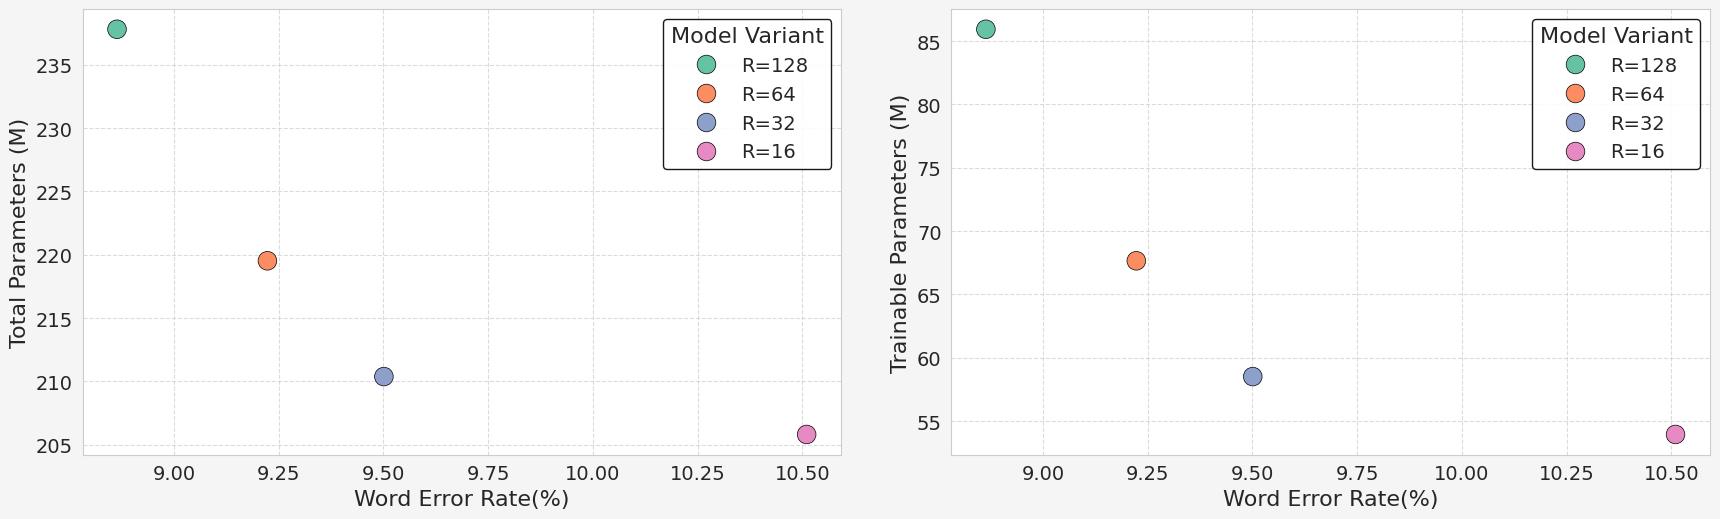

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data from CSV files
df_total = pd.read_csv("total_params_libri_dora.csv")
df_total["Total parameters"] = (
    df_total["Total parameters"] / 1_000_000
)  # Convert to millions

df_trainable = pd.read_csv("train_params_libri_dora.csv")
df_trainable["Trainable parameters"] = (
    df_trainable["Trainable parameters"] / 1_000_000
)  # Convert to millions

# Set seaborn style with enhancements
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Set font parameters for LaTeX compatibility
plt.rcParams.update(
    {
        "font.size": 18,  # Base font size
        "axes.titlesize": 18,  # Title font size (increased for consistency)
        "axes.labelsize": 16,  # Axis label font size (increased for consistency)
        "xtick.labelsize": 14,  # X tick label size (increased for readability)
        "ytick.labelsize": 14,  # Y tick label size (increased for readability)
        "legend.fontsize": 14,  # Legend font size (increased for readability)
        "legend.title_fontsize": 16,  # Legend title font size (increased for consistency)
    }
)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot for Total Parameters
scatter1 = sns.scatterplot(
    data=df_total,
    x="Time per step",
    y="Total parameters",
    hue="name",
    s=180,  # Slightly reduced point size
    alpha=1,
    edgecolor="black",
    linewidth=0.5,
    ax=ax1,
    legend="brief",
)

# Plot for Trainable Parameters
scatter2 = sns.scatterplot(
    data=df_trainable,
    x="Time per step",
    y="Trainable parameters",
    hue="name",
    s=180,
    alpha=1,
    edgecolor="black",
    linewidth=0.5,
    ax=ax2,
    legend="brief",
)

# Customize axes
ax1.set_xlabel("Word Error Rate(%)")
ax1.set_ylabel("Total Parameters (M)")
ax1.grid(True, linestyle="--", alpha=0.7)

ax2.set_xlabel("Word Error Rate(%)")
ax2.set_ylabel("Trainable Parameters (M)")
ax2.grid(True, linestyle="--", alpha=0.7)

# Get handles and labels from the plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Remove the auto-generated legends first
ax1.get_legend().remove()
ax2.get_legend().remove()

# Add legend to the first plot (ax1)
ax1.legend(
    handles=handles1,
    labels=labels1,
    title="Model Variant",
    loc="upper right",
    frameon=True,
    edgecolor="black",
    facecolor="white",
    framealpha=0.9,
)

# Add legend to the second plot (ax2)
ax2.legend(
    handles=handles2,
    labels=labels2,
    title="Model Variant",
    loc="upper right",
    frameon=True,
    edgecolor="black",
    facecolor="white",
    framealpha=0.9,
)

# Adjust layout with extra padding
plt.tight_layout(pad=2.0)

# Add subtle background color
fig.patch.set_facecolor("#f5f5f5")

# Display the plot
plt.show()

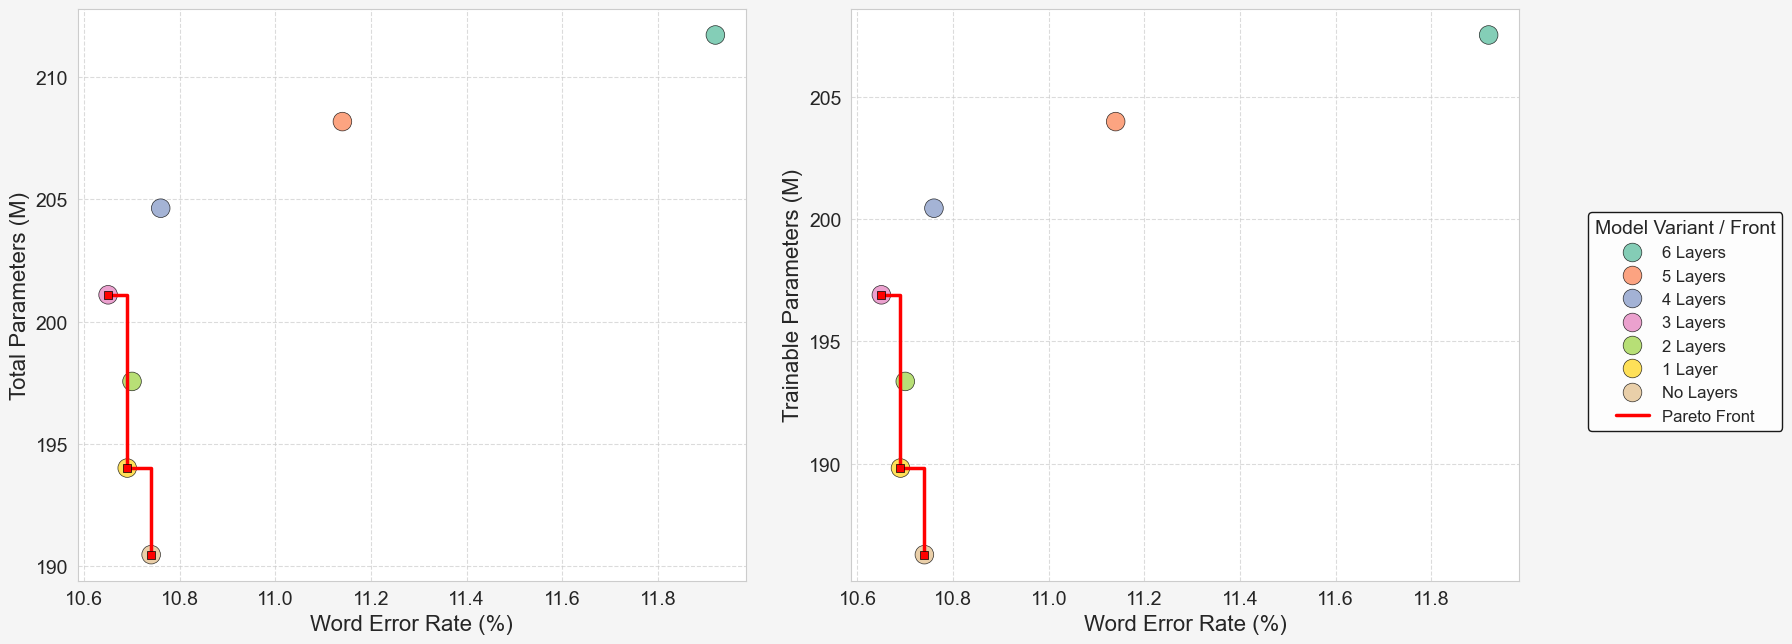

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np  # Import numpy for boolean indexing


# --- Function to identify Pareto optimal points ---
def identify_pareto(scores):
    """
    Identify the Pareto optimal points from a set of scores.
    Assumes lower scores are better for all objectives.

    Args:
        scores (np.ndarray): An array where each row is a point and each
                             column is an objective score.

    Returns:
        np.ndarray: A boolean array indicating which points are Pareto optimal.
    """
    population_size = scores.shape[0]
    pareto_front = np.ones(
        population_size, dtype=bool
    )  # Assume all are optimal initially
    for i in range(population_size):
        # Check if point 'i' is dominated by any other point 'j'
        for j in range(population_size):
            if i == j:
                continue
            # Check if 'j' dominates 'i':
            # 'j' must be <= 'i' in all objectives AND < 'i' in at least one objective
            if np.all(scores[j] <= scores[i]) and np.any(scores[j] < scores[i]):
                pareto_front[i] = False  # Mark 'i' as dominated
                break  # No need to check further for 'i'
    return pareto_front


# --- Function to plot the stair-step Pareto front ---
def plot_pareto_front_stair_step(
    ax,
    pareto_points_df,
    x_col,
    y_col,
    color="red",
    linestyle="-",
    linewidth=2,
    marker="s",
    markersize=5,
    highlight=True,
):
    """Plots the Pareto front with a stair-step pattern."""
    # Sort points for plotting: primarily by x, secondarily by y (though y sorting might not be strictly needed after filtering)
    pareto_points_df = pareto_points_df.sort_values(
        by=[x_col, y_col], ascending=[True, True]
    )
    x_pareto = pareto_points_df[x_col].values
    y_pareto = pareto_points_df[y_col].values

    if len(x_pareto) == 0:
        return  # Nothing to plot

    # Highlight the Pareto points themselves
    if highlight:
        ax.scatter(
            x_pareto,
            y_pareto,
            c=color,
            s=markersize * 6,
            marker=marker,
            label="_nolegend_",
            zorder=5,
            edgecolors="black",
            linewidth=0.5,
        )  # Make pareto points stand out slightly

    # Create stair-step coordinates
    x_coords = []
    y_coords = []
    if len(x_pareto) > 0:
        # Start from the first point
        x_coords.append(x_pareto[0])
        y_coords.append(y_pareto[0])

        # Add intermediate points for stairs
        for i in range(len(x_pareto) - 1):
            # Horizontal segment
            x_coords.append(x_pareto[i + 1])
            y_coords.append(y_pareto[i])
            # Vertical segment
            x_coords.append(x_pareto[i + 1])
            y_coords.append(y_pareto[i + 1])

    # Plot the stair-step line
    # Use a generic label or no label to avoid cluttering the main legend
    ax.plot(
        x_coords,
        y_coords,
        color=color,
        linestyle=linestyle,
        linewidth=linewidth,
        label="Pareto Front",
        zorder=4,
    )  # Add label for legend


# --- Load Data ---
# Use dummy data if files are not available
try:
    df_total = pd.read_csv("total_params_vox.csv")
    df_trainable = pd.read_csv("train_params_vox.csv")
except FileNotFoundError:
    print("CSV files not found, using dummy data.")
    # Create some plausible dummy data for demonstration
    data = {
        "name": [
            "Model A",
            "Model B",
            "Model C",
            "Model D",
            "Model E",
            "Model F",
            "Model G",
            "Model H",
        ],
        "Time per step": [15, 12, 10, 14, 9, 11, 13, 8],  # Actually WER %
        "Total parameters": [50, 70, 90, 60, 110, 80, 75, 120],
        "Trainable parameters": [40, 50, 80, 55, 90, 70, 65, 100],
    }
    dummy_df = pd.DataFrame(data)
    df_total = dummy_df[["name", "Time per step", "Total parameters"]].copy()
    df_trainable = dummy_df[["name", "Time per step", "Trainable parameters"]].copy()


# --- Data Preprocessing ---
df_total["Total parameters"] = df_total["Total parameters"] / 1_000_000
df_trainable["Trainable parameters"] = df_trainable["Trainable parameters"] / 1_000_000

# --- Plotting Setup ---
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams.update(
    {
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 12,  # Slightly smaller legend font for potentially more items
        "legend.title_fontsize": 14,
    }
)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(18, 7), sharey=False
)  # Increased height slightly
fig.patch.set_facecolor("#f5f5f5")

# === Plot 1: Total Parameters ===
x_col1 = "Time per step"  # This seems to represent WER based on label
y_col1 = "Total parameters"
hue_col = "name"

# Scatter plot for all points
scatter1 = sns.scatterplot(
    data=df_total,
    x=x_col1,
    y=y_col1,
    hue=hue_col,
    s=180,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    ax=ax1,
    legend="brief",  # Keep brief legend initially
)

# Identify and plot Pareto front for Total Parameters
scores_total = df_total[[x_col1, y_col1]].values
pareto_mask_total = identify_pareto(scores_total)
pareto_points_total = df_total[pareto_mask_total]

plot_pareto_front_stair_step(
    ax1, pareto_points_total, x_col1, y_col1, color="red", linewidth=2.5, markersize=6
)

# Customize axes
ax1.set_xlabel("Word Error Rate (%)")  # Corrected label
ax1.set_ylabel("Total Parameters (M)")
ax1.grid(True, linestyle="--", alpha=0.7)


# === Plot 2: Trainable Parameters ===
x_col2 = "Time per step"  # This seems to represent WER based on label
y_col2 = "Trainable parameters"

# Scatter plot for all points
scatter2 = sns.scatterplot(
    data=df_trainable,
    x=x_col2,
    y=y_col2,
    hue=hue_col,
    s=180,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    ax=ax2,
    legend="brief",
)

# Identify and plot Pareto front for Trainable Parameters
scores_trainable = df_trainable[[x_col2, y_col2]].values
pareto_mask_trainable = identify_pareto(scores_trainable)
pareto_points_trainable = df_trainable[pareto_mask_trainable]

plot_pareto_front_stair_step(
    ax2,
    pareto_points_trainable,
    x_col2,
    y_col2,
    color="red",
    linewidth=2.5,
    markersize=6,
)

# Customize axes
ax2.set_xlabel("Word Error Rate (%)")  # Corrected label
ax2.set_ylabel("Trainable Parameters (M)")
ax2.grid(True, linestyle="--", alpha=0.7)


# === Legend Handling ===
# Combine handles and labels from both scatter plots and the Pareto front line
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Keep only unique model names and the Pareto Front label
unique_labels = {}
combined_handles = []
combined_labels = []

# Process handles/labels from ax1
for handle, label in zip(handles1, labels1):
    if label not in unique_labels:
        unique_labels[label] = handle
        combined_handles.append(handle)
        combined_labels.append(label)

# Process handles/labels from ax2 (add only if not already present)
for handle, label in zip(handles2, labels2):
    if label not in unique_labels:
        # Heuristic: Check if it's a Pareto label or a model label
        if "Pareto" in label and label not in unique_labels:  # Add Pareto if not added
            unique_labels[label] = handle
            combined_handles.append(handle)
            combined_labels.append(label)
        elif (
            "Pareto" not in label and label not in unique_labels
        ):  # Add model if not added
            unique_labels[label] = handle
            combined_handles.append(handle)
            combined_labels.append(label)


# Remove the auto-generated legends first
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Add a single combined legend outside the plots (or adjust position as needed)
fig.legend(
    handles=combined_handles,
    labels=combined_labels,
    title="Model Variant / Front",
    loc="center right",  # Position outside plot area
    bbox_to_anchor=(1.01, 0.5),  # Adjust anchor to place it nicely
    frameon=True,
    edgecolor="black",
    facecolor="white",
    framealpha=0.9,
)

# Adjust layout with extra padding to accommodate the legend
plt.tight_layout(
    pad=1.5, rect=[0, 0, 0.88, 1]
)  # Adjust right boundary for external legend

# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your CSV data
df_libri = pd.read_csv("wer_libri.csv")
df_vox = pd.read_csv("wer_vox.csv")

# Define prefixes
libri_prefix = (
    "librispeech_asr_clean_split-train.100_wav2vec2-bart_bs64_lr0.0003_ep5.0_"
)
vox_prefix = "facebook/voxpopuli_en_split-train_wav2vec2-bart_bs96_lr0.0001_ep6.0_"

# Define runs for both datasets
runs = {
    "6 Layers": {"suffix": "a64x"},
    "5 Layers": {"suffix": "a32x"},
    "4 Layers": {"suffix": "a16x"},
    "3 Layers": {"suffix": "a8x"},
    "2 Layers": {"suffix": "a4x"},
    "1 Layers": {"suffix": "a2x"},
    "No Layers": {"suffix": "noa"},
}


# Function to prepare data
def prepare_plot_data(df, prefix):
    plot_df = df[["train/global_step"]].copy()
    for label, info in runs.items():
        wer_col = f"{prefix}{info['suffix']} - eval/wer"
        dev_wer_col = f"{prefix}{info['suffix']} - eval/dev_wer"
        plot_df[label] = df[wer_col]

        # Replace last step with dev_wer
        final_step = df["train/global_step"].max()
        last_index = plot_df["train/global_step"].idxmax()
        dev_wer_value = df[dev_wer_col].iloc[-1]
        plot_df.loc[last_index, label] = (
            dev_wer_value if pd.notna(dev_wer_value) else None
        )
    return plot_df


# Prepare data for both datasets
plot_df_libri = prepare_plot_data(df_libri, libri_prefix)
plot_df_vox = prepare_plot_data(df_vox, vox_prefix)

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Set font parameters
plt.rcParams.update(
    {
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "legend.title_fontsize": 16,
    }
)

# Create figure with two subplots side by side (removed sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))


# Function to create plot
def create_plot(ax, plot_df, title):
    for label in runs.keys():
        sns.lineplot(
            data=plot_df,
            x="train/global_step",
            y=label,
            label=label,
            linewidth=1.5,
            alpha=1,
            ax=ax,
        )

    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Word Error Rate (WER)")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.7)

    # Set x-axis ticks
    xticks = list(plot_df["train/global_step"])
    xticklabels = [str(x) for x in plot_df["train/global_step"]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)

    # Customize legend
    leg = ax.legend(
        title="Model Variant",
        loc="upper right",
        frameon=True,
        edgecolor="black",
        facecolor="white",
        framealpha=0.9,
    )
    for line in leg.get_lines():
        line.set_linewidth(10.0)


# Create plots
create_plot(ax1, plot_df_libri, "LibriSpeech Dataset")
create_plot(ax2, plot_df_vox, "VoxPopuli Dataset")

# Adjust layout
plt.tight_layout(pad=2.0)
fig.patch.set_facecolor("#f5f5f5")

# Display the plot
plt.show()